# Let's explore EXFOR offerings for Pb206

In [1]:
import pickle
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

In [2]:
import exfor_tools
import jitr

Using database version x4i3_X4-2023-04-29 located in: /home/beyerk/mambaforge/envs/sage/lib/python3.11/site-packages/x4i3/data


In [3]:
proton = (1, 1)
neutron = (1, 0)

In [4]:
target =(206,82)

In [5]:
all_entries_pp = exfor_tools.get_exfor_differential_data(
    target=target,
    projectile=(1, 1),
    quantity="dXS/dA",
    product="EL",
    energy_range=[10, 200],  # MeV
)

In [6]:
# these are considered outliers or not useful
entries_to_ignore = ['C1283']
for entry in entries_to_ignore:
    del all_entries_pp[entry]

In [7]:
all_entries_pp

{'C0672': <exfor_tools.exfor_tools.ExforDifferentialData at 0x72aa6eff4510>}

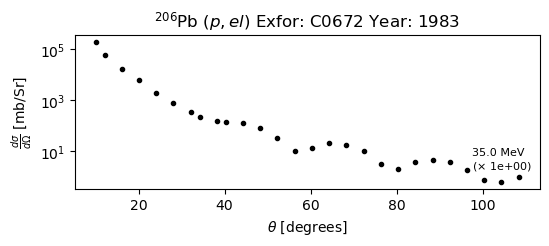

In [8]:
for entry, data in all_entries_pp.items():

    N = len(data.measurements)
    if N < 10:
        fig, ax = plt.subplots(1, 1, figsize=(6, 2 * N))
        data.plot_experiment(
            ax,
            xlim=None,
            offsets=10,
            label_energy_err=False,
            label_hloc_deg=np.max(data.measurements[0].data[0, :]) * 0.9,
        )
        yr = data.meta["year"]
        ax.set_title(f"{data.fancy_label} Exfor: {entry} Year: {yr}")
    else:
        N_plots = N // 10
        remaining = N % 10
        if remaining > 0:
            N_plots +=1
        for i in range(N_plots):
            fig, ax = plt.subplots(1, 1, figsize=(6, 20))
            data.plot_experiment(
                ax,
                data.measurements[i * N_plots: (i+1)*N_plots],
                xlim=None,
                offsets=10,
                label_energy_err=False,
                label_hloc_deg=np.max(data.measurements[0].data[0, :]) * 0.9,
            )
        yr = data.meta["year"]
        ax.set_title(f"{data.fancy_label} Exfor: {entry} Year: {yr}")

In [9]:
all_entries_pp_ruth = exfor_tools.get_exfor_differential_data(
    target=target,
    projectile=(1, 1),
    quantity="dXS/dRuth",
    product="EL",
    energy_range=[10, 200],  # MeV
)

In [10]:
all_entries_pp_ruth

{'O0788': <exfor_tools.exfor_tools.ExforDifferentialData at 0x72aa6e738cd0>}

In [11]:
# these are considered outliers or not useful
entries_to_ignore = []
for entry in entries_to_ignore:
    del all_entries_pp_ruth[entry]

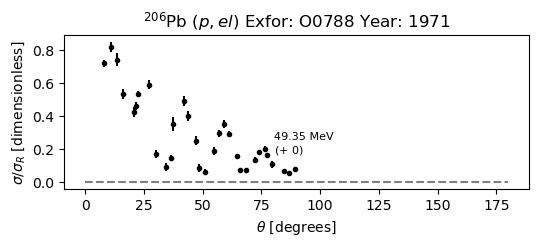

In [12]:
for entry, data in all_entries_pp_ruth.items():

    N = len(data.measurements)
    fig, ax = plt.subplots(1, 1, figsize=(6, 2 * N))

    data.plot_experiment(
        ax,
        xlim=None,
        offsets=2,
        label_energy_err=False,
        label_hloc_deg=np.max(data.measurements[0].data[0, :]) * 0.9,
        label_offset_factor=0.1,
        log=False,
        add_baseline=True,
    )
    yr = data.meta["year"]
    ax.set_title(f"{data.fancy_label} Exfor: {entry} Year: {yr}")

In [13]:
all_entries_nn = exfor_tools.get_exfor_differential_data(
    target=target,
    projectile=(1, 0),
    quantity="dXS/dA",
    product="EL",
    energy_range=[10, 200],  # MeV
)

In [14]:
all_entries_nn

{'10633': <exfor_tools.exfor_tools.ExforDifferentialData at 0x72aa6e1ae790>,
 '22048': <exfor_tools.exfor_tools.ExforDifferentialData at 0x72aa6eea9210>,
 '40288': <exfor_tools.exfor_tools.ExforDifferentialData at 0x72aa6df3f1d0>}

In [15]:
# these are considered outliers or not useful
entries_to_ignore = ['40288']
for entry in entries_to_ignore:
    del all_entries_nn[entry]

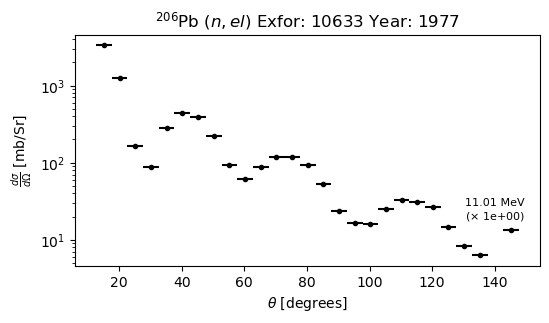

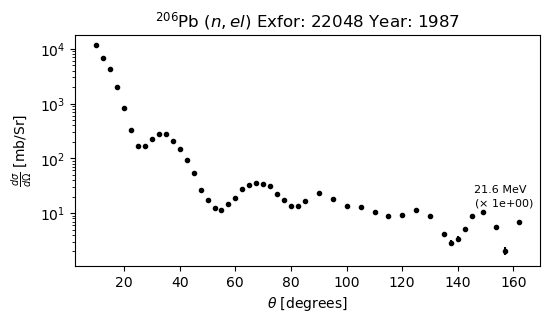

In [16]:
for entry, data in all_entries_nn.items():
    
    N = len(data.measurements)
    fig, ax = plt.subplots(1, 1, figsize=(6, 3*N))

    data.plot_experiment(
        ax,
        xlim=None,
        offsets=50,
        label_energy_err=False,
        label_hloc_deg=np.max(data.measurements[0].data[0,:])*0.9,
    )
    yr = data.meta["year"]
    ax.set_title(f"{data.fancy_label} Exfor: {entry} Year: {yr}")

In [17]:
from periodictable import elements
A,Z = target
with open(f"{elements[Z]}{A}_n_elastic.pkl" , "wb") as f:
    pickle.dump(all_entries_nn, f)

with open(f"{elements[Z]}{A}_p_elastic.pkl" , "wb") as f:
    pickle.dump( {"xs" : all_entries_pp , "ratio" : all_entries_pp_ruth}, f)